In [194]:
import torch
import torch.nn as nn
import numpy as np
import scipy.signal
import random
import gym
from torch.distributions.categorical import Categorical

In [195]:
def discount_cumsum(x, discount):
    """
    magic from rllab for computing discounted cumulative sums of vectors.
    input: 
        vector x, 
        [x0, 
         x1, 
         x2]
    output:
        [x0 + discount * x1 + discount^2 * x2,  
         x1 + discount * x2,
         x2]
    """
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]


In [196]:
class PPOBuffer:
    """
    A buffer for storing trajectories experienced by a PPO agent interacting
    with the environment, and using Generalized Advantage Estimation (GAE-Lambda)
    for calculating the advantages of state-action pairs.
    """

    def __init__(self, obs_dim, act_dim, size, gamma=0.99, lam=0.95):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.act_buf = np.zeros(size, dtype=np.float32)
        self.adv_buf = np.zeros(size, dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.ret_buf = np.zeros(size, dtype=np.float32)
        self.val_buf = np.zeros(size, dtype=np.float32)
        self.logp_buf = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.ptr, self.path_start_idx, self.max_size = 0, 0, size

    def is_full(self):
        return self.ptr == self.max_size

    def store(self, obs, act, rew, val, logp):
        """
        Append one timestep of agent-environment interaction to the buffer.
        """
        assert self.ptr < self.max_size     # buffer has to have room so you can store
        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.val_buf[self.ptr] = val
        self.logp_buf[self.ptr] = logp
        self.ptr += 1

    def finish_path(self, last_val=0):
        """
        Call this at the end of a trajectory, or when one gets cut off
        by an epoch ending. This looks back in the buffer to where the
        trajectory started, and uses rewards and value estimates from
        the whole trajectory to compute advantage estimates with GAE-Lambda,
        as well as compute the rewards-to-go for each state, to use as
        the targets for the value function.

        The "last_val" argument should be 0 if the trajectory ended
        because the agent reached a terminal state (died), and otherwise
        should be V(s_T), the value function estimated for the last state.
        This allows us to bootstrap the reward-to-go calculation to account
        for timesteps beyond the arbitrary episode horizon (or epoch cutoff).
        """

        path_slice = slice(self.path_start_idx, self.ptr)
        rews = np.append(self.rew_buf[path_slice], last_val)
        vals = np.append(self.val_buf[path_slice], last_val)
        
        # the next two lines implement GAE-Lambda advantage calculation
        deltas = rews[:-1] + self.gamma * vals[1:] - vals[:-1]
        self.adv_buf[path_slice] = discount_cumsum(deltas, self.gamma * self.lam)
        
        # the next line computes rewards-to-go, to be targets for the value function
        self.ret_buf[path_slice] = discount_cumsum(rews, self.gamma)[:-1]
        
        # self.path_start_idx = self.ptr

    def get(self):
        """
        Call this at the end of an epoch to get all of the data from
        the buffer, with advantages appropriately normalized (shifted to have
        mean zero and std one). Also, resets some pointers in the buffer.
        """
        # assert self.ptr == self.max_size    # buffer has to be full before you can get
        path_slice = slice(self.path_start_idx, self.ptr)
        obs_buf = self.obs_buf[path_slice]
        act_buf = self.act_buf[path_slice]
        ret_buf = self.ret_buf[path_slice]
        adv_buf = self.adv_buf[path_slice]
        logp_buf = self.logp_buf[path_slice]
        
        # the next two lines implement the advantage normalization trick
        adv_mean, adv_std = adv_buf.mean(), adv_buf.std() # 1/|D_k| ?
        adv_buf = (adv_buf - adv_mean) / adv_std

        data = dict(obs=obs_buf, act=act_buf, ret=ret_buf,
                    adv=adv_buf, logp=logp_buf)
        self.ptr, self.path_start_idx = 0, 0
        return {k: torch.as_tensor(v, dtype=torch.float32) for k,v in data.items()}

In [197]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Tanh()
        )                

    def _distribution(self, obs):        
        logits = self.net(obs)
        # assert logits[0, 0].item() <= 1 and logits[0, 0].item() >= 0
        return Categorical(logits=logits)

    def _log_prob_from_distribution(self, pi, act):        
        return pi.log_prob(act)

    def forward(self, obs, act=None):
        pi_dist = self._distribution(obs)
        logp_a = None
        if act is not None:
            logp_a = self._log_prob_from_distribution(pi_dist, act)
        return pi_dist, logp_a

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )        
    def forward(self, obs):
        return self.net(obs)


class Actor_Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64, optim_pi_lr=1e-3, optim_v_lr=1e-3):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.pi = Actor(state_dim, action_dim, hidden_dim)
        self.v = Critic(state_dim, action_dim, hidden_dim)
        self.optim_pi = torch.optim.Adam(self.pi.parameters(), lr=optim_pi_lr)
        self.optim_v = torch.optim.Adam(self.v.parameters(), lr=optim_v_lr)

    def step(self, obs):
        with torch.no_grad():
            pi = self.pi._distribution(obs)
            a = pi.sample()
            logp_a = self.pi._log_prob_from_distribution(pi, a)
            v = self.v(obs)
        return a.numpy(), v.numpy(), logp_a.numpy()



In [198]:
def PPO(env, steps_per_epoch=4000, gamma=0.99, lam=0.95, lr=3e-4, clip_ratio=0.2, epochs=1000, hidden_dim=64, optim_pi_lr=0.001 * 0.3, optim_v_lr=0.001, train_pi_iters=80, train_v_iters=80, render=False, target_kl=0.01, test_freq=10):    
    """
    PPO algorithm
    """    
    pi_loss_vec = []
    v_loss_vec = []
    ewma_reward_vec = []
    ewma_reward = 0

    # Random seed
    seed = random.randint(0, 100000)
    torch.manual_seed(seed)
    np.random.seed(seed)

    ac = Actor_Critic(state_dim=env.observation_space.shape[0], action_dim=env.action_space.n,
        hidden_dim=hidden_dim, 
        optim_pi_lr=optim_pi_lr, 
        optim_v_lr=optim_v_lr
    )
    # set up experience replay buffer
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    buf = PPOBuffer(obs_dim=state_dim, act_dim=action_dim, size=steps_per_epoch, gamma=gamma, lam=lam)

    # takes in the buffer output
    def compute_pi_loss(data):
        obs, act, adv, logp_old = data['obs'], data['act'], data['adv'], data['logp']
        _, logp = ac.pi(obs, act) # get the log prob of the chosen action
        importance_weight = torch.exp(logp - logp_old)
        clip_adv = torch.clamp(importance_weight, 1-clip_ratio, 1+clip_ratio) * adv
        loss_pi = -torch.min(importance_weight*adv, clip_adv).mean() # batch as unit

        # Useful extra info
        approx_kl = (logp_old - logp).mean().item()
        ent = None
        clipped = importance_weight.gt(1+clip_ratio) | importance_weight.lt(1-clip_ratio)
        clipfrac = torch.as_tensor(clipped, dtype=torch.float32).mean().item()
        pi_info = dict(kl=approx_kl, ent=ent, cf=clipfrac)
        return loss_pi, pi_info
    
    def compute_v_loss(data):
        obs, ret = data['obs'], data['ret']
        v = ac.v(obs)
        return ((ret - v)**2).mean()

    def update():
        data = buf.get()

        pi_l_old, pi_info_old = compute_pi_loss(data)
        pi_l_old = pi_l_old.item()
        v_l_old = compute_v_loss(data).item()
        pi_loss_vec.append(pi_l_old)
        v_loss_vec.append(v_l_old)

        # Train policy with multiple steps of gradient descent
        for i in range(train_pi_iters):
            ac.optim_pi.zero_grad()
            loss_pi, pi_info = compute_pi_loss(data)
            kl = pi_info['kl']            
            if kl > 1.5 * target_kl:
                print('Early stopping at step %d due to reaching max kl.'%i)
                break
            loss_pi.backward()
            ac.optim_pi.step()  

        for i in range(train_v_iters):
            ac.optim_v.zero_grad()
            loss_v = compute_v_loss(data)
            loss_v.backward()
            ac.optim_v.step()
    
    # explore                
    for epoch in range(epochs):   
        done = False
        state, ep_ret, ep_len = env.reset(), 0, 0
        for step in range(steps_per_epoch):
            action, val, logp = ac.step(torch.as_tensor(state, dtype=torch.float32))

            next_state, reward, done, _ = env.step(action)
            ep_ret += reward
            ep_len += 1

            buf.store(obs=state, act=action, rew=reward, val=val, logp=logp)

            state = next_state

            timeout = step == steps_per_epoch - 1
            if timeout or done:            
                if timeout:
                    _, v, _ = ac.step(torch.as_tensor(state, dtype=torch.float32))
                else:  # done
                    v = 0
                buf.finish_path(v)
                break
        
        # update for every epoch              
        update()

        # test         
        if epoch % test_freq == 0:
            test_rw = 0
            state = env.reset()
            for step in range(steps_per_epoch):
                action, _, _ = ac.step(torch.as_tensor(state, dtype=torch.float32))
                state, reward, done, _ = env.step(action)
                test_rw += reward
                if done:
                    break
            ewma_reward = 0.05 * test_rw + (1 - 0.05) * ewma_reward
            ewma_reward_vec.append(ewma_reward)
            print(f"Epoch: {epoch}, test reward: {test_rw}, ewma reward: {ewma_reward}")
        
    return pi_loss_vec, v_loss_vec, ewma_reward_vec

In [199]:
import matplotlib.pyplot as plt

env = gym.make('CartPole-v0')
pi_losses, v_losses, ewma_reward_vec = PPO(env)

Early stopping at step 16 due to reaching max kl.
Epoch: 0, test reward: 19.0, ewma reward: 0.9500000000000001
Early stopping at step 45 due to reaching max kl.
Early stopping at step 18 due to reaching max kl.
Early stopping at step 36 due to reaching max kl.
Early stopping at step 14 due to reaching max kl.
Epoch: 10, test reward: 12.0, ewma reward: 1.5025
Early stopping at step 5 due to reaching max kl.
Early stopping at step 8 due to reaching max kl.
Early stopping at step 6 due to reaching max kl.
Early stopping at step 11 due to reaching max kl.
Early stopping at step 61 due to reaching max kl.
Early stopping at step 6 due to reaching max kl.
Early stopping at step 4 due to reaching max kl.
Epoch: 20, test reward: 132.0, ewma reward: 8.027375000000001
Early stopping at step 3 due to reaching max kl.
Early stopping at step 7 due to reaching max kl.
Early stopping at step 11 due to reaching max kl.
Early stopping at step 16 due to reaching max kl.
Early stopping at step 11 due to r

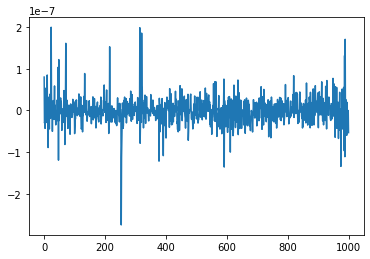

In [200]:
plt.plot(pi_losses)
plt.show()

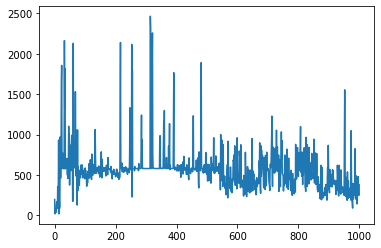

In [201]:
plt.plot(v_losses)
plt.show()

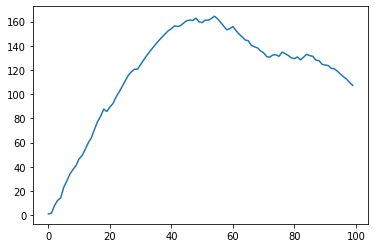

In [202]:
plt.plot(ewma_reward_vec)
plt.show()

In [22]:
import torch
heads = torch.Tensor([0.2, 0.1, 0.5, 0.3])
arr = np.zeros(4)
for i in range(100):
    arr[torch.multinomial(heads, 1, replacement=True).item()] += 1

tensor([0])
tensor([0])
